<a href="https://colab.research.google.com/github/dsankush/image_denoising/blob/main/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this script please ensure that the required datasts are uploaded to google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import zipfile
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import os

from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, LeakyReLU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras import regularizers
import keras.backend as kb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) 

In [ ]:
import zipfile

# Will unzip the files so that you can see them..
files = ['train','test','train_cleaned']
for file in files:
    with zipfile.ZipFile("/content/drive/MyDrive/"+file+".zip",'r') as z:
        z.extractall(".")

In [ ]:
import glob 
target_width = 540
target_height = 420
def load_image(path):
    file_list = glob.glob(path+'/*.png')
    file_list.sort()
    img_list = np.empty((len(file_list), target_height, target_width, 1))
    for i, fig in enumerate(file_list):
        img = load_img(fig, color_mode='grayscale', target_size=(target_height, target_width))
        img_array = img_to_array(img).astype('float32')
        img_array = img_array / 255.0
        img_list[i] = img_array
    
    return img_list

def train_test_split(data,random_seed=55,split=0.75):
    set_rdm = np.random.RandomState(seed=random_seed)
    dsize = len(data)
    ind = set_rdm.choice(dsize,dsize,replace=False)
    train_ind = ind[:int(0.75*dsize)]
    val_ind = ind[int(0.75*dsize):]
    return data[train_ind],data[val_ind]

def augment_pipeline(pipeline, images, seed=5):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)
train_img = os.listdir('train')
train_cleaned_img = os.listdir('train_cleaned')
test_img = os.listdir('test')

In [ ]:
input_shape = (420, 540, 1)


In [ ]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (input_shape[1], input_shape[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, input_shape)
    
    return img

In [ ]:

train = []
train_cleaned = []
test = []

directory = 'train'
for f in sorted(os.listdir(directory)):
    train.append(process_image(os.path.join(directory, f)))
                               
directory = 'train_cleaned'                            
for f in sorted(os.listdir(directory)):
    train_cleaned.append(process_image(os.path.join(directory, f)))

directory = 'test'                               
for f in sorted(os.listdir(directory)):
    test.append(process_image(os.path.join(directory, f)))

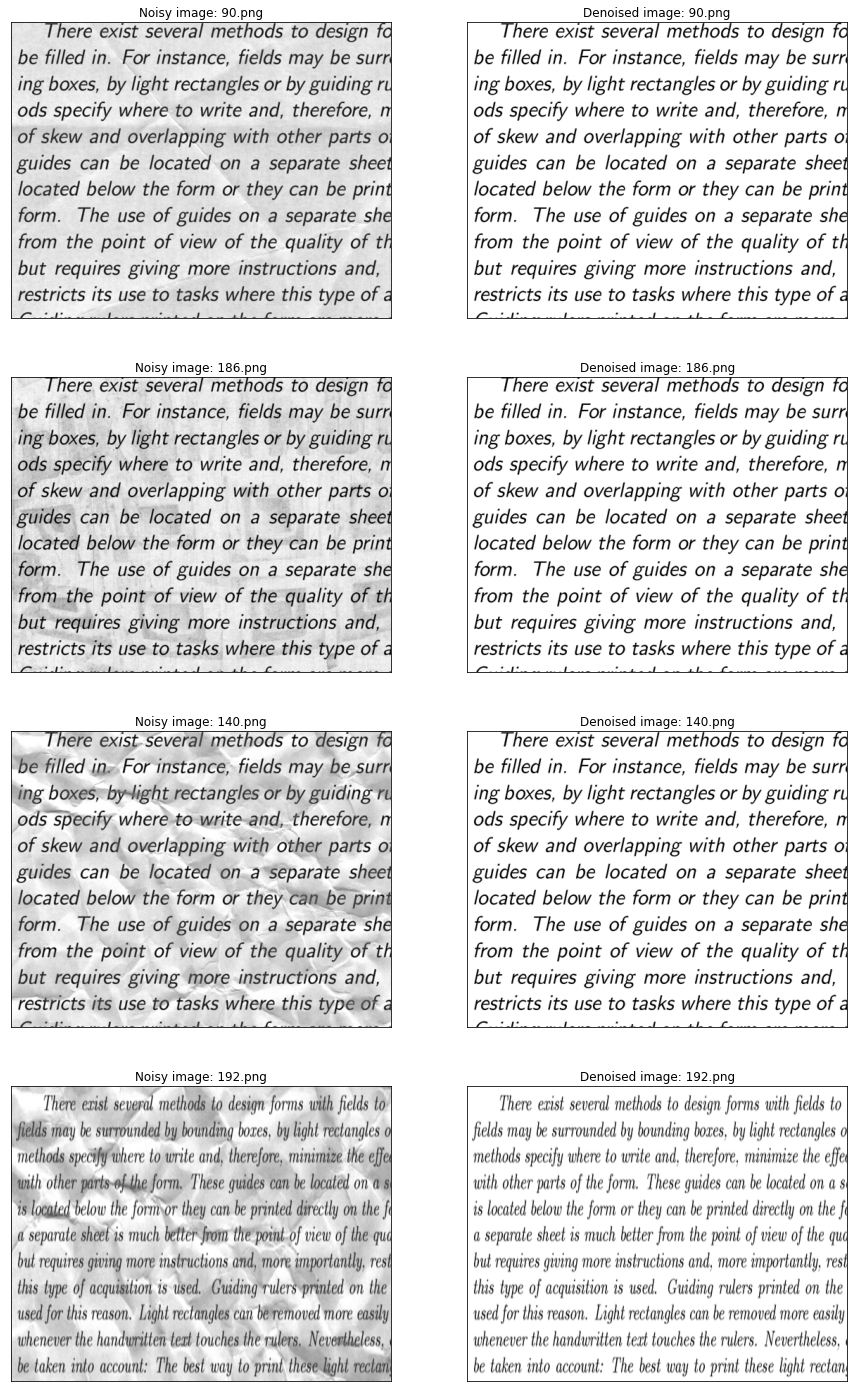

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()